Поколение 0: Лучшее приспособленность = 205
Достигнуто оптимальное расписание на поколении 0


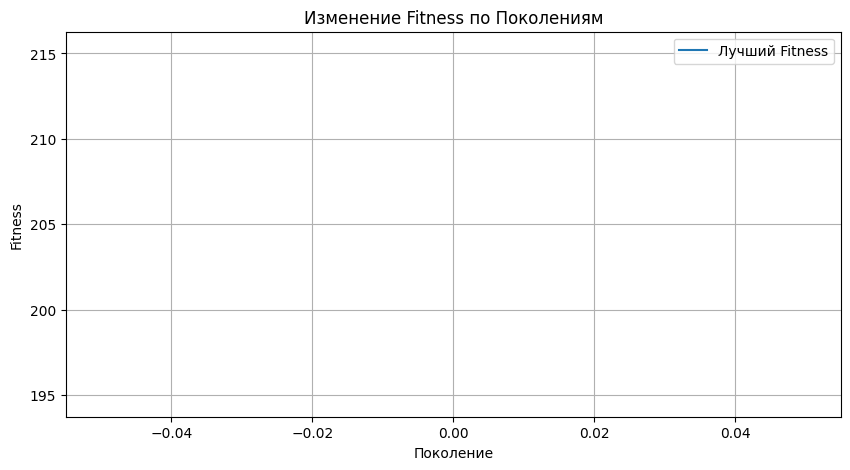


Лучшее найденное расписание:
+------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+
| Действие   | Водитель 1                         | Водитель 2                         | Водитель 3                         | Водитель 4                         | Водитель 5                         | Водитель 6                     | Водитель 7                     | Водитель 8                     | Водитель 9                     |
+============+====================================+====================================+====================================+====================================+====================================+================================+================================+================================+========

In [2]:
import random
from datetime import datetime, timedelta
from tabulate import tabulate
import matplotlib.pyplot as plt


POPULATION_SIZE = 300       
GENERATIONS = 1000
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 5
ELITISM_COUNT = 10        

drivers = [f"Водитель {i+1}" for i in range(9)]

PEAK_TIMES = [
    (datetime.strptime("07:00", "%H:%M").time(), datetime.strptime("09:00", "%H:%M").time()),  # Утренний пик
    (datetime.strptime("17:00", "%H:%M").time(), datetime.strptime("19:00", "%H:%M").time()),  # Вечерний пик
]

# Преобразование времени в минуты с 00:00
def time_to_minutes(time_str):
    t = datetime.strptime(time_str, '%H:%M')
    return t.hour * 60 + t.minute

# Преобразование минут с 00:00 в строку времени
def minutes_to_time(minutes):
    minutes = minutes % (24 * 60)  # Корректировка на следующий день
    return (datetime(100, 1, 1) + timedelta(minutes=minutes)).strftime('%H:%M')

# Проверка, попадает ли время в пиковый интервал
def is_peak_time(time_min):
    time_obj = (datetime(100, 1, 1) + timedelta(minutes=time_min)).time()
    for peak_start, peak_end in PEAK_TIMES:
        if peak_start <= time_obj < peak_end:
            return True
    return False

# Генерация начальной популяции
def generate_initial_population():
    population = []
    for _ in range(POPULATION_SIZE):
        chromosome = []
        # Выбираем случайного водителя, который будет начинать в 06:00
        early_driver = random.randint(0, len(drivers)-1)
        for i in range(len(drivers)):
            if i == early_driver:
                start_time = time_to_minutes("06:00")
            else:
                if i < 5:
                    # Водители 1-5: 06:00 - 18:30 (чтобы смена завершалась до 03:00 ночи)
                    start_time = random.choice(range(time_to_minutes("06:00"), time_to_minutes("18:30") + 1, 15))
                else:
                    # Водители 6-9: 12:00 - 19:00
                    start_time = random.choice(range(time_to_minutes("12:00"), time_to_minutes("19:00") + 1, 15))
            chromosome.append(start_time)
            if i < 5:
                # Первые 5 водителей: два коротких перерыва
                break1 = start_time + 3 * 60  # Через 3 часа
                break2 = start_time + 6 * 60  # Через 6 часов
                chromosome.append(break1)
                chromosome.append(break2)
            else:
                # Остальные водители: один большой перерыв
                break1 = start_time + 4 * 60  # Через 4 часа
                chromosome.append(break1)
                chromosome.append(-1)  # Нет второго перерыва
        population.append(chromosome)
    return population

# Функция приспособленности
def fitness(chromosome):
    penalty = 0
    reward = 0
    peak_driver_count = {"morning": 0, "evening": 0}
    late_shift_found = False  # Флаг для проверки, есть ли водитель, работающий до 03:00
    early_shift_found = False  # Флаг для проверки, есть ли водитель, начинающий в 06:00
    
    start_times = [chromosome[i * 3] for i in range(len(drivers))]
    
    # Проверка, есть ли водитель, начинающий в 06:00
    if 360 in start_times:
        early_shift_found = True
        reward += 50  # Бонус за выполнение требования
    else:
        penalty += 100  # Значительный штраф за невыполнение требования
    
    for i in range(len(drivers)):
        start_time = chromosome[i * 3]
        if i < 5:
            break1 = chromosome[i * 3 + 1]
            break2 = chromosome[i * 3 + 2]
            end_time = start_time + 8 * 60 + 30  # 8 часов работы + два перерыва по 15 минут
            # Проверка окончания смены
            if end_time > time_to_minutes("03:00"):
                late_shift_found = True
            # Проверка перерывов на пиковые часы
            if is_peak_time(break1):
                penalty += 5  # Уменьшен штраф
            else:
                reward += 10  # Увеличен бонус
            if is_peak_time(break2):
                penalty += 5  # Уменьшен штраф
            else:
                reward += 10  # Увеличен бонус
            # Проверка точности перерывов
            if (break1 - start_time) != 3 * 60:
                penalty += 2  # Уменьшен штраф
            if (break2 - start_time) != 6 * 60:
                penalty += 2  # Уменьшен штраф
        else:
            break1 = chromosome[i * 3 + 1]
            end_time = start_time + 8 * 60 + 60  # 8 часов работы + 1 час перерыв
            # Проверка окончания смены
            if end_time > time_to_minutes("03:00"):
                late_shift_found = True
            # Проверка перерыва на пиковые часы
            if is_peak_time(break1):
                penalty += 5  # Уменьшен штраф
            else:
                reward += 10  # Увеличен бонус
            # Проверка точности перерыва
            if (break1 - start_time) != 4 * 60:
                penalty += 2  # Уменьшен штраф
    
    # Подсчёт количества водителей во время пиковых часов
    for i in range(len(drivers)):
        start_time = chromosome[i * 3]
        if i < 5:
            # Водители 1-5
            break1 = chromosome[i * 3 + 1]
            break2 = chromosome[i * 3 + 2]
            work_intervals = [
                (start_time, break1),
                (break1 + 15, break2),
                (break2 + 15, start_time + 8 * 60 + 30)
            ]
        else:
            # Водители 6-9
            break1 = chromosome[i * 3 + 1]
            work_intervals = [
                (start_time, break1),
                (break1 + 60, start_time + 8 * 60 + 60)
            ]
        for interval in work_intervals:
            for peak_label, peak in [("morning", PEAK_TIMES[0]), ("evening", PEAK_TIMES[1])]:
                peak_start_min = time_to_minutes(peak[0].strftime('%H:%M'))
                peak_end_min = time_to_minutes(peak[1].strftime('%H:%M'))
                overlap_start = max(interval[0], peak_start_min)
                overlap_end = min(interval[1], peak_end_min)
                if overlap_start < overlap_end:
                    peak_driver_count[peak_label] += 1
    
    # Добавление бонусов и штрафов за количество водителей во время пиковых часов
    optimal_peak_drivers = 5
    for peak_label in peak_driver_count:
        actual = peak_driver_count[peak_label]
        if actual > optimal_peak_drivers:
            penalty += (actual - optimal_peak_drivers) * 1  # Уменьшен штраф
        elif actual < optimal_peak_drivers:
            penalty += (optimal_peak_drivers - actual) * 2  # Увеличен штраф
        # Бонус за соответствие
        if actual == optimal_peak_drivers:
            reward += 15  # Уменьшен бонус для баланса
    
    # Проверка, есть ли хотя бы один водитель, работающий до 03:00
    if not late_shift_found:
        penalty += 50  # Штраф за отсутствие водителя, работающего до 03:00
    
    return reward - penalty

# Селекция методом турнира
def tournament_selection(population, fitnesses):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), TOURNAMENT_SIZE)
        tournament = sorted(tournament, key=lambda x: x[1], reverse=True)  # Сортировка по фитнесу (больше лучше)
        selected.append(tournament[0][0])
    return selected

# Одноточечный кроссовер
def crossover(parent1, parent2):
    if len(parent1) != len(parent2):
        raise ValueError("Длина родителей должна быть одинаковой")
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

# Мутация: случайное изменение гена
def mutate(chromosome):
    for i in range(len(chromosome)):
        if random.random() < MUTATION_RATE:
            if i % 3 == 0:
                # Время начала смены на 15-минутных интервалах
                if i // 3 < 5:
                    chromosome[i] = random.choice(range(time_to_minutes("06:00"), time_to_minutes("18:30") + 1, 15))
                else:
                    chromosome[i] = random.choice(range(time_to_minutes("12:00"), time_to_minutes("19:00") + 1, 15))
                # Перерасчет перерывов после мутации времени начала смены
                if i // 3 < 5:
                    chromosome[i + 1] = chromosome[i] + 3 * 60
                    chromosome[i + 2] = chromosome[i] + 6 * 60
                else:
                    chromosome[i + 1] = chromosome[i] + 4 * 60
            elif i % 3 == 1:
                # Первый перерыв: через 3 или 4 часа
                if i // 3 < 5:
                    chromosome[i] = chromosome[i - 1] + 3 * 60
                else:
                    chromosome[i] = chromosome[i - 1] + 4 * 60
            elif i % 3 == 2:
                # Второй перерыв или фиктивное значение
                if (i // 3) < 5:
                    chromosome[i] = chromosome[i - 2] + 6 * 60
                else:
                    chromosome[i] = -1  # Для водителей 6-9
    return chromosome

# Кроссовер для всей популяции
def crossover_population(population):
    new_population = []
    for i in range(0, len(population), 2):
        parent1 = population[i]
        parent2 = population[i+1] if i+1 < len(population) else population[0]
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([child1, child2])
    return new_population

# Главный цикл генетического алгоритма с визуализацией фитнеса
def genetic_algorithm():
    population = generate_initial_population()
    fitness_history = []
    for generation in range(GENERATIONS):
        fitnesses = [fitness(individual) for individual in population]
        fitness_history.append(max(fitnesses))
        # Сортировка популяции по фитнесу (больше лучше)
        sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[1], reverse=True)]
        sorted_fitnesses = sorted(fitnesses, reverse=True)
        
        # Вывод лучших результатов каждые 100 поколений и при достижении оптимума
        if generation % 100 == 0 or generation == GENERATIONS - 1:
            print(f"Поколение {generation}: Лучшее приспособленность = {sorted_fitnesses[0]}")
        
        # Проверка на завершение (если фитнес достаточно высокий)
        if sorted_fitnesses[0] >= 100:
            print(f"Достигнуто оптимальное расписание на поколении {generation}")
            break
        
        # Элитизм: сохраняем лучших родителей
        new_population = sorted_population[:ELITISM_COUNT]
        
        # Селекция
        selected = tournament_selection(population, fitnesses)
        
        # Кроссовер
        children = crossover_population(selected)
        
        # Добавляем детей в популяцию
        new_population.extend(children)
        
        # Обрезаем популяцию до размера
        population = new_population[:POPULATION_SIZE]
        
        # Мутация
        population = [mutate(individual) for individual in population]
    
    # Финальная оценка
    fitnesses = [fitness(individual) for individual in population]
    max_fitness = max(fitnesses)
    best_index = fitnesses.index(max_fitness)
    best_chromosome = population[best_index]
    
    # Построение графика фитнеса
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, label='Лучший Fitness')
    plt.xlabel('Поколение')
    plt.ylabel('Fitness')
    plt.title('Изменение Fitness по Поколениям')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_chromosome, max_fitness

# Визуализация расписания
def visualize_schedule(chromosome):
    schedule = {driver: [] for driver in drivers}
    for i in range(len(drivers)):
        start_time = chromosome[i * 3]
        if i < 5:
            # Водители 1-5: два коротких перерыва
            break1 = chromosome[i * 3 + 1]
            break2 = chromosome[i * 3 + 2]
            end_time = start_time + 8 * 60 + 30  # 8 часов работы + два перерыва по 15 минут
            schedule[drivers[i]].append((start_time, "Начало смены"))
            schedule[drivers[i]].append((break1, "Короткий перерыв (15 минут)"))
            schedule[drivers[i]].append((break2, "Короткий перерыв (15 минут)"))
            schedule[drivers[i]].append((end_time, "Окончание смены"))
        else:
            # Водители 6-9: один большой перерыв
            break1 = chromosome[i * 3 + 1]
            end_time = start_time + 8 * 60 + 60  # 8 часов работы + 1 час перерыв
            schedule[drivers[i]].append((start_time, "Начало смены"))
            schedule[drivers[i]].append((break1, "Большой перерыв (1 час)"))
            schedule[drivers[i]].append((end_time, "Окончание смены"))
    
    # Сортировка действий по времени
    for driver in drivers:
        schedule[driver].sort(key=lambda x: x[0])
    
    # Создание таблицы для вывода
    table = []
    max_actions = max(len(actions) for actions in schedule.values())
    
    for action_idx in range(max_actions):
        row = [f"Действие {action_idx + 1}"]
        for driver in drivers:
            if action_idx < len(schedule[driver]):
                time_min, action = schedule[driver][action_idx]
                if time_min == -1:
                    cell = '-'
                else:
                    time_str = minutes_to_time(time_min)
                    # Добавить подпись (час пик) к "Начало смены"
                    if "Начало смены" in action:
                        if is_peak_time(time_min):
                            action += " (час пик)"
                    cell = f"{time_str}: {action}"
            else:
                cell = '-'
            row.append(cell)
        table.append(row)
    
    # Создание заголовков таблицы
    headers = ["Действие"] + drivers
    
    # Вывод таблицы с использованием 'tabulate'
    formatted_table = tabulate(table, headers=headers, tablefmt='grid', stralign='left')
    print(formatted_table)

# Генерация и вывод расписания
best_chromosome, best_fitness = genetic_algorithm()
print("\nЛучшее найденное расписание:")
visualize_schedule(best_chromosome)
